# 実験_バッチサイズ・学習率

累積勾配(Gradient Accumulation)　あり・なしで、学習の安定性を比較する。

## 初期化

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

fastaiのimport

In [2]:
from fastai.vision.all import *
from fastai.callback.fp16 import *    # Mixed Precisionで学習するときに必要

その他のライブラリのimport

In [3]:
from pathlib import Path
import tqdm
import json
import glob
from torchsummary import summary
import datetime  # fastai？に上書きされないように。

環境とfastaiのバージョン確認

In [4]:
%%script false
from fastai.test_utils import show_install; show_install()

# 出力内容
# === Software === 
# python        : 3.9.10
# fastai        : 2.6.3
# fastcore      : 1.3.27
# fastprogress  : 1.0.2
# torch         : 1.11.0+cu113
# nvidia driver : 512.77
# torch cuda    : 11.3 / is available
# torch cudnn   : 8200 / is enabled

# === Hardware === 
# nvidia gpus   : 2
# torch devices : 2
#   - gpu0      : NVIDIA GeForce RTX 3070 Ti
#   - gpu1      : NVIDIA GeForce GTX 1070

# === Environment === 
# platform      : Windows-10-10.0.19044-SP0
# conda env     : Unknown
# python        : C:/Users/User/AppData/Local/Programs/Python/Python39/python.exe
# sys.path      : ...


Couldn't find program: 'false'


## パラメータ

In [5]:
bs_step = 64      # 計算時のバッチサイズ
bs_update = 1024  # 勾配更新時のバッチサイズ
imsize_pre=256
imsize_croped=224
np.random.seed(42)

## データ準備

fastaiの機能でデータセット取得、約1.8GB

In [6]:
# データのルートフォルダ
img_root_path = untar_data(URLs.PETS) 

データセットのフォルダ構成確認。imagesフォルダなどがある。

In [41]:
[p.relative_to(img_root_path) for p in img_root_path.ls()]

[Path('annotations'),
 Path('crappy'),
 Path('images'),
 Path('image_gen'),
 Path('models')]

今回はimagesフォルダのデータだけ使う。

In [8]:
# 前処理前の画像のフォルダ
img_original_path = img_root_path/'images'

In [9]:
# 前処理後の画像を配置するフォルダ
img_preprocessed_path = Path('D:/bulk/dataset/image/PETS/train256') 

画像のpathへのリストを取得。画像は約7000件

In [10]:
files = get_image_files(img_original_path); len(files)

7390

## DataLoaders定義

- [Data Block API](https://docs.fast.ai/data.block.html)でデータセットの画像・ラベルの読み込み方法を指定。
- DataBlockからDataLoadersを作成

In [11]:
def label_number(p:Path)->str:
    "画像のパスから正解ラベルを取得"
    return str(p.name).split('_')[0]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),   # ImageとCategoryを１サンプルとする
    get_items=get_image_files,                           # itemの集合の取得関数の指定。get_image_files(path)の出力、つまりPathのリストをitemsとする。
    splitter=RandomSplitter(valid_pct=0.2),              # train/validの分割方法。　20%をvalidにする
    get_y=label_number,                                  # ラベルの取得方法。　label_number(path)
    item_tfms=CropPad(256),                                      # 入力画像を読込むときの変換
    batch_tfms=aug_transforms(size=imsize_croped),       # バッチ処理するときの変換。オーグメンテーションを指定。
    n_inp=1
)

dls = dblock.dataloaders(img_preprocessed_path, batch_size=bs_step)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


## Learner定義

### Model定義

今回は自作Modelを定義する。転移学習時のパラメータ固定範囲のためにsplitterが必要。

In [12]:
class Net(Module):
    def __init__(self, arch=resnet34, nc=dls.c, pretrained=True):
        self.body = create_body(arch, pretrained=pretrained)
        nf = num_features_model(nn.Sequential(*self.body.children()))
        self.head = create_head(nf,nc,lin_ftrs=[nc*4])
        
    def forward(self, x):    
        x = self.body(x)
        return self.head(x)
        
def splitter(model:Net):
    """
    Model分割方法の指示。
    転移学習のとき、どこまでパラメータ固定するか判断するのに使用する。
    今回は、Modelパラメータをbodyとheadの２つに分けた。
    """
    return [params(model.body), params(model.head)]        


### Metrics
学習中に表示する評価指標。fastai標準の関数のほかに、任意の関数を定義して利用できる。

今回は、「MAP(Mean Average Precision)@10」をMetricに追加する。

In [13]:
SCORE_TEMPLATE = (1/(torch.arange(10)+1)).cuda()  # 例）tensor([1.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250, 0.1111, 0.1000])
def map10(preds:Tensor, ans:Tensor):
    "評価関数「MAP（Mean Average Precision）@10」"
    assert preds.ndim==2, f'期待：preds.ndim==2, actual:{preds.ndim}. (batch_size, cls_confidence)'
    confidence = preds.argsort(descending=True)[:,:10]
    n_sample = len(preds)
    score = 0
    for pred, y in zip(confidence, ans):
        mask = torch.eq(pred,y).type(torch.uint8)  # 正解なら1のマスク　例）TensorCategory([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
        score += torch.sum(SCORE_TEMPLATE*mask)
    return score/n_sample


### Learnerを作成

In [14]:
def make_learn(cbs:list=[]):
    model = Net()
    learn = Learner(dls, model=model,
                    splitter=splitter,           
                    loss_func=F.cross_entropy,   
                    metrics=[accuracy, map10],
                    cbs=[ShowGraphCallback()]+cbs
    ).to_fp16()
    return learn


※備考

- [ShowGraphCallback()](https://docs.fast.ai/callback.progress.html#ShowGraphCallback) : 学習中にtrain/validのロスをグラフ表示
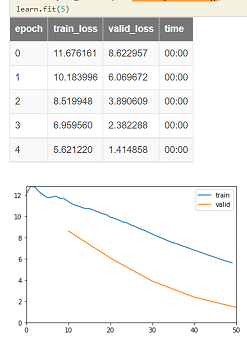

- `.to_fp16()` : Mixed Precisionを使用

GPUメモリ使用量の確認

In [15]:
f'{torch.cuda.max_memory_allocated()*1e-9:.3g}GB'

'0.00259GB'

# 累積勾配なしの場合

In [16]:
learn = make_learn()
learn.freeze()
lr=1e-2  # 仮の学習率

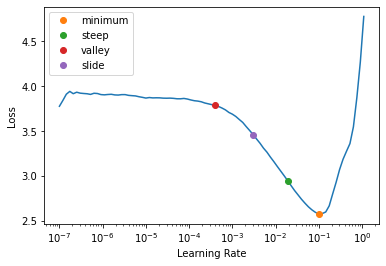

In [17]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [18]:
lr = max(lrs); lr, lrs

(0.019054606556892395,
 SuggestedLRs(minimum=0.010000000149011612, steep=0.019054606556892395, valley=0.0003981071640737355, slide=0.0030199517495930195))

epoch,train_loss,valid_loss,accuracy,map10,time
0,0.905246,0.450905,0.847091,0.909345,00:21
1,0.993336,1.845038,0.488498,0.643688,00:25
2,0.986548,1.408815,0.609608,0.737934,00:31
3,0.749186,0.709016,0.769959,0.860062,00:31
4,0.629156,0.700822,0.778078,0.865690,00:31
5,0.532126,0.393990,0.867388,0.922710,00:21
6,0.425365,0.380137,0.870771,0.922900,00:19
7,0.334642,0.315200,0.895805,0.938672,00:19
8,0.256339,0.296191,0.895805,0.939152,00:20
9,0.229112,0.297574,0.899865,0.941234,00:20


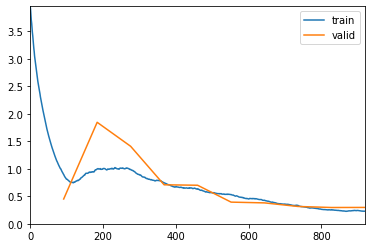

In [19]:
learn.fit_one_cycle(10, lr_max=lr)

結果のうち、Accuracyだけ保存しておく

In [20]:
learn.recorder.values

[(#4) [0.9052463173866272,0.4509047269821167,0.8470906615257263,0.9093450307846069],
 (#4) [0.9933357238769531,1.8450379371643066,0.4884979724884033,0.6436883807182312],
 (#4) [0.9865480661392212,1.4088146686553955,0.6096075773239136,0.7379338145256042],
 (#4) [0.7491856813430786,0.7090158462524414,0.7699593901634216,0.8600615859031677],
 (#4) [0.629155695438385,0.700822114944458,0.7780784964561462,0.8656898140907288],
 (#4) [0.5321260690689087,0.39399027824401855,0.8673883676528931,0.9227099418640137],
 (#4) [0.42536506056785583,0.38013726472854614,0.8707712888717651,0.9229003190994263],
 (#4) [0.3346416652202606,0.3151996433734894,0.8958051204681396,0.9386722445487976],
 (#4) [0.25633928179740906,0.2961905896663666,0.8958051204681396,0.9391517639160156],
 (#4) [0.229111909866333,0.29757392406463623,0.899864673614502,0.9412341117858887]]

In [21]:
acc = {}

In [22]:
acc['bs64'] = [x[2] for x in learn.recorder.values]

In [23]:
acc

{'bs64': [0.8470906615257263,
  0.4884979724884033,
  0.6096075773239136,
  0.7699593901634216,
  0.7780784964561462,
  0.8673883676528931,
  0.8707712888717651,
  0.8958051204681396,
  0.8958051204681396,
  0.899864673614502]}

# 累積勾配ありの場合

同じ学習率で、累積勾配ありで計算

In [33]:
learn = make_learn(cbs=[GradientAccumulation(n_acc=bs_update)])
learn.freeze()

累積勾配ありでlr_find　... 計算失敗してる？

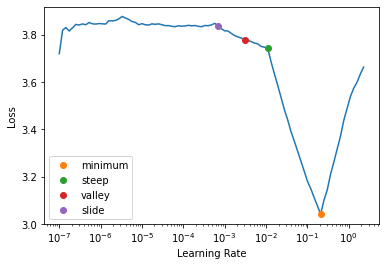

In [34]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [27]:
lr = max(lrs); lr, lrs

(0.02290867641568184,
 SuggestedLRs(minimum=0.010000000149011612, steep=0.02290867641568184, valley=0.0020892962347716093, slide=0.004365158267319202))

epoch,train_loss,valid_loss,accuracy,map10,time
0,2.043479,0.976039,0.830176,0.896414,00:19
1,0.832854,0.400275,0.875507,0.925448,00:19
2,0.472426,0.368026,0.878214,0.928345,00:19
3,0.387759,0.384239,0.878890,0.928347,00:19
4,0.349319,0.330284,0.899865,0.942441,00:19
5,0.325585,0.327717,0.895129,0.939628,00:19
6,0.294805,0.340541,0.887686,0.935839,00:19
7,0.262151,0.325038,0.895129,0.937631,00:19
8,0.225308,0.305263,0.901894,0.941743,00:19
9,0.205135,0.302533,0.902571,0.942552,00:19


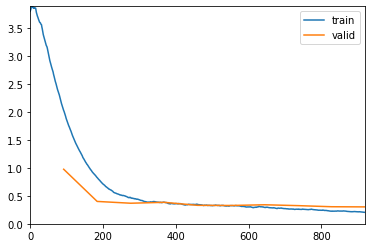

In [28]:
learn.fit_one_cycle(10, lr_max=lr)

In [29]:
acc['bs1024'] = [x[2] for x in learn.recorder.values]

In [30]:
df = pd.DataFrame(acc)

bs_updateによる学習安定性の比較

<AxesSubplot:xlabel='n_epoch', ylabel='acc'>

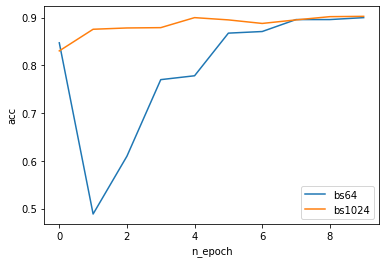

In [31]:
df.plot(xlabel='n_epoch', ylabel='acc')